# Antifraud AI system

In [1]:
import pandas as pd
import numpy as np
import ciso8601
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import vaex

# Загрузка данных

In [2]:
mcc_types = pd.read_excel('./data/Типы_MCC.xlsx')
mcc_types.head()

,MCC,Наименование,Категория
0,742,Ветеринарные услуги,Контрактные услуги
1,763,Сельско-хозяйственные кооперативные общества,Контрактные услуги
2,780,Ландшафтные и садоводческие магазины,Контрактные услуги
3,1520,Генеральные подрядчики – жилищное и торговое с...,Контрактные услуги
4,1711,"Генеральные подрядчики по вентиляции, теплосна...",Контрактные услуги


In [3]:
history = pd.read_csv('./data/hashed_hist_trx.csv')
history

,Unnamed: 0,event_id_hashed,user_id_hashed,atm_merchant_name_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
0,0,044dbd9f85fe3483b6732620dd08a922ba3890ae,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,e7821ba367bb20589a2a1bd1750ad35259d96da4,2018-12-06 09:33:21,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5921.0,R,280.00
1,1,2cd8ad1e72456a8659819e89d93992b9e58491da,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,c9a38668a219e58e2d6f487d9a97fd11f11b413e,2018-12-06 09:36:08,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,376.90
2,2,aea228355a7e4c72f629b65ef48e6e77ebc2e35d,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,e7821ba367bb20589a2a1bd1750ad35259d96da4,2018-12-06 12:21:02,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5921.0,R,143.00
3,3,9b7ec39e26353eeb2a9ed02dfb9af83a7d8f79c6,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,c9a38668a219e58e2d6f487d9a97fd11f11b413e,2018-12-06 07:46:58,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,162.00
4,4,4d00403100c5ae8e7e8f239b75568a6f8729cf97,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,c9a38668a219e58e2d6f487d9a97fd11f11b413e,2018-12-06 12:21:27,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,56.00
...,...,...,...,...,...,...,...,...,...,...,...
562485,562485,0f0ae854bbc4f63006352afbf31b7f76ac74b8e2,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,9ccc9c8a881041091f8287d3a3905cfa4feb702e,2018-11-27 18:14:11,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5411.0,R,273.57
562486,562486,24b13abd3bf9733da38f35ffc2c0ab79ffb3ce59,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,09b1b707de6a11d9b35b2a346a39e4a4069869d4,2018-11-27 19:18:13,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,4829.0,U,7500.00
562487,562487,21f9479f129b700f4239bdabac1ae457f7ab219e,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,09b1b707de6a11d9b35b2a346a39e4a4069869d4,2018-11-27 19:17:27,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,4829.0,U,2000.00
562488,562488,049d78dc6981bb03e9ab204785c9ada835352c88,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,98a5305ee2f8894d28ec306ee0c260b47955e290,2018-11-27 07:20:05,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5999.0,R,110.00


In [4]:
hits = pd.read_csv('./data/hashed_hits0712.csv')
hits

,Unnamed: 0,event_id_hashed,user_id_hashed,rec_user_id_hashed,date_time,resolution,sub_channel
0,0,c1481cfd0e53b970b93c1084aa21f61e24eafe3c,89fddd281a556e16a4605c7a4660032f444d055f,6d54925a6cadb371cdb476b5468cdb84b2a8572f,2018-12-07 07:56:49,G,ATMAPI
1,1,a360c37072f0fce211289ed3513a10f95e4ced15,c082376aa8c24e4058e06b0e131fa11214bc1564,af52314731caade51ca856f999c80f1c6fa220af,2018-12-07 07:14:41,G,MOBILEAPI
2,2,514a1640fa8d3d501819acb268bf8e0601be0413,269132a6caf55a1714aa8b2892f49bfb9d4f83f9,83d53e493b306b3de48eb4dc8cececd09cb3f0b5,2018-12-07 14:02:30,G,MOBILEAPI
3,3,17171ba57b27af84c1d7656cea1670d8b07d53a3,23742da28085cf1e92d6df174bf858664125d237,cef7e5d273864f0d011c601b4923b0c24e6779ee,2018-12-07 10:32:41,G,WEBAPI
4,4,d3a4dbaf779774d814ae9f7fc54d854947fda95f,0d2f9a408ec5fb2a934b32c9decd9ec9c176fd96,2497c2592921d73bec74da82fb5745cb95a9687f,2018-12-07 18:22:52,G,MOBILEAPI
...,...,...,...,...,...,...,...
9011,9011,a8d5ef9c299ad0047c57badabb809a215034c6f8,e167db4a3a2caf730f97cbeecb3c78b0c40d6e81,42992ea12969dd276ad137198764e022ec1789f2,2018-12-07 17:46:35,G,MOBILEAPI
9012,9012,cd7e2ed15d8f7d072bf80d2b788969e56683dc62,854da9d080beecddc6427c69436dcf42c096985a,1137e7a77f6abaa25a46c19002e0a909c919f939,2018-12-07 18:42:47,G,WEBAPI
9013,9013,b8cf8f54d4afeb7e50f4a32a518a6c513ec54cbb,0596a0cf8f05f47e6c56b9711678d57dfcc37172,f40733027fc854d0e5d870a415317241bdda23c9,2018-12-07 13:55:59,G,MOBILEAPI
9014,9014,642bbe5eb669ca6803b6eae4dac67b4f8067e8ae,aeadfaa074545f33b5e38d247447759b0e5f634f,274e47c7687bdf7a982160d67a98ce253c5ef0f0,2018-12-07 17:55:32,G,ATMAPI


# Обработка исторических данных

In [5]:
history = history[history.date_time < '2018-12-07']
history

,Unnamed: 0,event_id_hashed,user_id_hashed,atm_merchant_name_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
0,0,044dbd9f85fe3483b6732620dd08a922ba3890ae,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,e7821ba367bb20589a2a1bd1750ad35259d96da4,2018-12-06 09:33:21,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5921.0,R,280.00
1,1,2cd8ad1e72456a8659819e89d93992b9e58491da,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,c9a38668a219e58e2d6f487d9a97fd11f11b413e,2018-12-06 09:36:08,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,376.90
2,2,aea228355a7e4c72f629b65ef48e6e77ebc2e35d,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,e7821ba367bb20589a2a1bd1750ad35259d96da4,2018-12-06 12:21:02,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5921.0,R,143.00
3,3,9b7ec39e26353eeb2a9ed02dfb9af83a7d8f79c6,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,c9a38668a219e58e2d6f487d9a97fd11f11b413e,2018-12-06 07:46:58,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,162.00
4,4,4d00403100c5ae8e7e8f239b75568a6f8729cf97,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,c9a38668a219e58e2d6f487d9a97fd11f11b413e,2018-12-06 12:21:27,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5331.0,R,56.00
...,...,...,...,...,...,...,...,...,...,...,...
562485,562485,0f0ae854bbc4f63006352afbf31b7f76ac74b8e2,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,9ccc9c8a881041091f8287d3a3905cfa4feb702e,2018-11-27 18:14:11,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5411.0,R,273.57
562486,562486,24b13abd3bf9733da38f35ffc2c0ab79ffb3ce59,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,09b1b707de6a11d9b35b2a346a39e4a4069869d4,2018-11-27 19:18:13,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,4829.0,U,7500.00
562487,562487,21f9479f129b700f4239bdabac1ae457f7ab219e,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,09b1b707de6a11d9b35b2a346a39e4a4069869d4,2018-11-27 19:17:27,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,4829.0,U,2000.00
562488,562488,049d78dc6981bb03e9ab204785c9ada835352c88,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,98a5305ee2f8894d28ec306ee0c260b47955e290,2018-11-27 07:20:05,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,5999.0,R,110.00


## Исследование пропущенных значений

In [6]:
history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562490 entries, 0 to 562489
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                562490 non-null  int64  
 1   event_id_hashed           562490 non-null  object 
 2   user_id_hashed            562490 non-null  object 
 3   atm_merchant_name_hashed  562490 non-null  object 
 4   date_time                 562490 non-null  object 
 5   sub_channel               562490 non-null  object 
 6   event_type                562490 non-null  object 
 7   sub_type                  562490 non-null  object 
 8   atm_mcc                   561354 non-null  float64
 9   mcc_group                 561350 non-null  object 
 10  amount                    562490 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 51.5+ MB


Пропуски есть в признаках **atm_mcc**, **mcc_group**, **atm_merchant_name_hashed**. Надо понять, в каких случаях есть пропуски, надо ли их заполнять и как.

In [7]:
na_rows = history[history.isna().any(axis=1)].copy()
na_rows

,Unnamed: 0,event_id_hashed,user_id_hashed,atm_merchant_name_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
67,67,d158eed0a9afa6a9a749bc2becafb78e84cb3754,f30e6b97cc83110b1e20edecd06f24f08a2dc8ed,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-12-06 13:14:24,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
90,90,8fede2c0dfa0c6833c6230644f18d38c9770622b,8a969cf951e1c49f993a1f5703fbf1b01d22f684,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-12-06 11:27:28,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
92,92,64bf0a53a915e5694455c0a341f5c9d8bbbac159,8a969cf951e1c49f993a1f5703fbf1b01d22f684,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-12-06 11:27:23,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
217,217,ae48af9867d2aea31cf209285f1a43b6ca3a657b,c85d95870ab8ca1fae9e36ffd235ec52a9f9cb7c,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-12-06 01:08:36,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
218,218,78990dd5f93186eb4f1d8789664d2cf5d6953d0b,c85d95870ab8ca1fae9e36ffd235ec52a9f9cb7c,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-12-06 01:08:23,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
561783,561783,ab1df87572e3a671ffb76fd5578826969176306a,af714077d405d175079a87fb596424b009695402,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-11-27 20:55:27,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
562259,562259,1ac4410cdd22a4a45442ff003620de3505e7244f,0d8383de08d7147f1de75e5149a298ef353467cf,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-11-27 07:30:50,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
562271,562271,be3bcfaa78b349fae14f223cada821eda1abffe2,0d8383de08d7147f1de75e5149a298ef353467cf,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-11-27 07:26:12,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0
562404,562404,80e8e54083741ecc13d24afbd8ce1eef725b5965,3faeccfacea5304acd2f6a51a8833a878e533ef5,6eef6648406c333a4035cd5e60d0bf2ecf2606d7,2018-11-27 17:57:38,ISSUER,CLIENT_DEFINED,TOKENIZATION_REQUEST,NaN,NaN,0.0


In [8]:
na_rows.describe()

,Unnamed: 0,atm_mcc,amount
count,1140.000000,4.0,1140.000000
mean,270395.712281,3301.0,0.400456
std,174021.688510,0.0,8.785712
min,67.000000,3301.0,0.000000
25%,127787.500000,3301.0,0.000000
50%,254703.500000,3301.0,0.000000
75%,421987.250000,3301.0,0.000000
max,562441.000000,3301.0,257.960000


In [9]:
na_rows[na_rows.amount > 0]

,Unnamed: 0,event_id_hashed,user_id_hashed,atm_merchant_name_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
104601,104601,0f6b517b7f1909fc7dae37cff3e3d55901b52ef3,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,c8f136cf7cc23bf628bdedf5908548e367ced46e,2018-12-05 09:50:56,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,137.18
268697,268697,f37b0409ab15f41e42258662873d7ad2c19fa562,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,c8f136cf7cc23bf628bdedf5908548e367ced46e,2018-12-02 10:01:36,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,10.01
268698,268698,1d0964dc19e4b581ef4b7cfafa3cf005a4d4a942,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,c8f136cf7cc23bf628bdedf5908548e367ced46e,2018-12-02 09:39:43,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,51.37
451312,451312,2cd02abf8efd44a3c98f34356bfc4937df744ca0,70ed021abc7d0250621c1390cacd7853c350ddc2,c8f136cf7cc23bf628bdedf5908548e367ced46e,2018-11-29 10:55:50,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,257.96


In [10]:
history.atm_merchant_name_hashed.unique().shape

(74655,)

Удалим признак **atm_merchant_name_hashed**, так как это категориальный признак с большим количеством уникальных значений, что не даст при начальном анализе дополнительной информации (возможна группировка по данным о *mcc*-кодах, но пропустим пока этот шаг), а привнесет в будущую модель огромное количество степеней свободы.

In [11]:
history.drop(['Unnamed: 0', 'atm_merchant_name_hashed'], axis=1, inplace=True)
na_rows.drop(['atm_merchant_name_hashed'], axis=1, inplace=True)

In [12]:
na_rows.event_type.unique()

array(['CLIENT_DEFINED', 'PAYMENT'], dtype=object)

In [13]:
na_rows[na_rows.amount > 0]

,Unnamed: 0,event_id_hashed,user_id_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
104601,104601,0f6b517b7f1909fc7dae37cff3e3d55901b52ef3,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,2018-12-05 09:50:56,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,137.18
268697,268697,f37b0409ab15f41e42258662873d7ad2c19fa562,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,2018-12-02 10:01:36,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,10.01
268698,268698,1d0964dc19e4b581ef4b7cfafa3cf005a4d4a942,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,2018-12-02 09:39:43,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,51.37
451312,451312,2cd02abf8efd44a3c98f34356bfc4937df744ca0,70ed021abc7d0250621c1390cacd7853c350ddc2,2018-11-29 10:55:50,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,257.96


In [14]:
na_rows[na_rows.event_type == 'PAYMENT']

,Unnamed: 0,event_id_hashed,user_id_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
104601,104601,0f6b517b7f1909fc7dae37cff3e3d55901b52ef3,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,2018-12-05 09:50:56,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,137.18
268697,268697,f37b0409ab15f41e42258662873d7ad2c19fa562,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,2018-12-02 10:01:36,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,10.01
268698,268698,1d0964dc19e4b581ef4b7cfafa3cf005a4d4a942,9d7f641bae8e5215aca971fbce0f0269cb19f5e8,2018-12-02 09:39:43,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,51.37
451312,451312,2cd02abf8efd44a3c98f34356bfc4937df744ca0,70ed021abc7d0250621c1390cacd7853c350ddc2,2018-11-29 10:55:50,ISSUER,PAYMENT,EPOS_PURCHASE,3301.0,NaN,257.96


In [15]:
neg_idx = na_rows[na_rows.atm_mcc.isna()].index.to_numpy()

In [16]:
history.loc[neg_idx, 'atm_mcc'] = -1

In [17]:
history.atm_mcc /= 10000

Посмотрим на распределение групп *mcc*-кодов

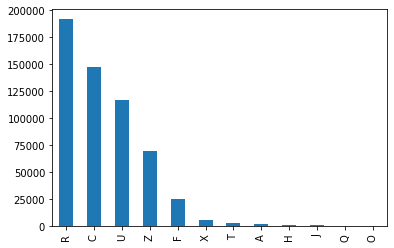

In [18]:
history.mcc_group.value_counts().plot(kind='bar')
plt.show()

Заметим, что группы *X, T, A, H, J, Q, O*, а также *NaN* встречаются достаточно редко. Поэтому такую подгруппу можно объединить в новую категорию *Others*

In [19]:
others_idx = history[history.mcc_group.isin(['X', 'T', 'A', 'H', 'J', 'Q', 'O']) | history.mcc_group.isna()].index.to_numpy()
history.loc[others_idx, 'mcc_group'] = 'Other'

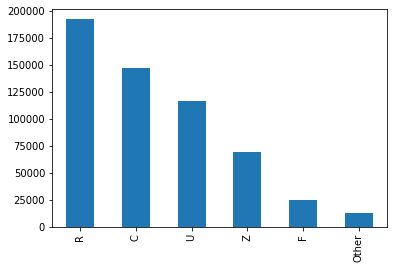

In [20]:
history.mcc_group.value_counts().plot(kind='bar')
plt.show()

In [21]:
history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562490 entries, 0 to 562489
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   event_id_hashed  562490 non-null  object 
 1   user_id_hashed   562490 non-null  object 
 2   date_time        562490 non-null  object 
 3   sub_channel      562490 non-null  object 
 4   event_type       562490 non-null  object 
 5   sub_type         562490 non-null  object 
 6   atm_mcc          562490 non-null  float64
 7   mcc_group        562490 non-null  object 
 8   amount           562490 non-null  float64
dtypes: float64(2), object(7)
memory usage: 59.0+ MB


Мы добились того, что пропуски заполнены: признак *atm_mcc* включает в себя числа от -0.0001 до 0.999, для того, чтобы модель не отдавала предпочтения, но и видела -1 как пропуск.

In [22]:
history

,event_id_hashed,user_id_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
0,044dbd9f85fe3483b6732620dd08a922ba3890ae,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 09:33:21,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5921,R,280.00
1,2cd8ad1e72456a8659819e89d93992b9e58491da,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 09:36:08,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,376.90
2,aea228355a7e4c72f629b65ef48e6e77ebc2e35d,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 12:21:02,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5921,R,143.00
3,9b7ec39e26353eeb2a9ed02dfb9af83a7d8f79c6,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 07:46:58,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,162.00
4,4d00403100c5ae8e7e8f239b75568a6f8729cf97,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 12:21:27,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,56.00
...,...,...,...,...,...,...,...,...,...
562485,0f0ae854bbc4f63006352afbf31b7f76ac74b8e2,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 18:14:11,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5411,R,273.57
562486,24b13abd3bf9733da38f35ffc2c0ab79ffb3ce59,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 19:18:13,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,0.4829,U,7500.00
562487,21f9479f129b700f4239bdabac1ae457f7ab219e,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 19:17:27,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,0.4829,U,2000.00
562488,049d78dc6981bb03e9ab204785c9ada835352c88,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 07:20:05,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5999,R,110.00


In [23]:
history.drop(['event_id_hashed'], axis=1, inplace=True)
history

,user_id_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount
0,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 09:33:21,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5921,R,280.00
1,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 09:36:08,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,376.90
2,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 12:21:02,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5921,R,143.00
3,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 07:46:58,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,162.00
4,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 12:21:27,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,56.00
...,...,...,...,...,...,...,...,...
562485,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 18:14:11,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5411,R,273.57
562486,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 19:18:13,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,0.4829,U,7500.00
562487,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 19:17:27,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,0.4829,U,2000.00
562488,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 07:20:05,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5999,R,110.00


## Добавление новых признаков

Есть два подхода работы со временем (не рассматриваем временные ряды): рассматривать время как временную метку (timestamp) или же получить из эти данных новые. Был выбран второй способ и на основе старых данных создадим 4 новых признака: часть дня совершения операции (ночь, утро, день, вечер) -- с разницей в 6 часов.

In [24]:
for r in tqdm(range(history.shape[0])):
    time_tmp = list(map(int, history.loc[r, 'date_time'].split(' ')[1].split(':')))
    if time_tmp[0]>=0 and time_tmp[1]>=0 and time_tmp[0]<=5 and time_tmp[1]<=59:
        history.loc[r, 'night_buy'] = 1
    elif time_tmp[0]>=6 and time_tmp[1]>=0 and time_tmp[0]<=11 and time_tmp[1]<=59:
        history.loc[r, 'morning_buy'] = 1
    elif time_tmp[0]>=12 and time_tmp[1]>=0 and time_tmp[0]<=17 and time_tmp[1]<=59:
        history.loc[r, 'day_buy'] = 1
    else:
        history.loc[r, 'evening_buy'] = 1

100%|██████████| 562490/562490 [17:30<00:00, 535.61it/s]


In [25]:
history.fillna(0, inplace=True)
history

,user_id_hashed,date_time,sub_channel,event_type,sub_type,atm_mcc,mcc_group,amount,morning_buy,day_buy,evening_buy,night_buy
0,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 09:33:21,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5921,R,280.00,1.0,0.0,0.0,0.0
1,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 09:36:08,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,376.90,1.0,0.0,0.0,0.0
2,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 12:21:02,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5921,R,143.00,0.0,1.0,0.0,0.0
3,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 07:46:58,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,162.00,1.0,0.0,0.0,0.0
4,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,2018-12-06 12:21:27,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5331,R,56.00,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
562485,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 18:14:11,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5411,R,273.57,0.0,0.0,1.0,0.0
562486,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 19:18:13,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,0.4829,U,7500.00,0.0,0.0,1.0,0.0
562487,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 19:17:27,ISSUER_ACQUIRER,PAYMENT,ATM_P2P_DEBIT,0.4829,U,2000.00,0.0,0.0,1.0,0.0
562488,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2018-11-27 07:20:05,ISSUER_ACQUIRER,PAYMENT,POS_PURCHASE,0.5999,R,110.00,1.0,0.0,0.0,0.0


In [26]:
history.drop(['date_time'], axis=1, inplace=True)

## Фактаризация данных и кодирования методом OneHot

Для того, чтобы не терять на данной этапе никаких данных, а максимально обогатить их, все категориальные признаки мы закодируем и добавим новые признаки.

In [27]:
sub_channel_factorized, sub_channles_categories = history.sub_channel.factorize()
encoder = OneHotEncoder()
sub_channel_1hot = encoder.fit_transform(sub_channel_factorized.reshape(-1, 1))
sub_channel_1hot = pd.DataFrame(sub_channel_1hot.toarray(), columns=sub_channles_categories)
history.drop(['sub_channel'], axis=1, inplace=True)
history = pd.concat([history, sub_channel_1hot], axis=1)

In [28]:
event_type_factorized, event_type_categories = history.event_type.factorize()
encoder = OneHotEncoder()
event_type_1hot = encoder.fit_transform(event_type_factorized.reshape(-1, 1))
event_type_1hot = pd.DataFrame(event_type_1hot.toarray(), columns=event_type_categories)
history = pd.concat([history, event_type_1hot], axis=1)

In [29]:
mcc_group_factorized, mcc_group_categories = history.mcc_group.factorize()
encoder = OneHotEncoder()
mcc_group_1hot = encoder.fit_transform(mcc_group_factorized.reshape(-1, 1))
mcc_group_1hot = pd.DataFrame(mcc_group_1hot.toarray(), columns=mcc_group_categories)
history = pd.concat([history, mcc_group_1hot], axis=1)
history.drop(['mcc_group'], axis=1, inplace=True)

In [30]:
sub_type_factorized, sub_type_categories = history.sub_type.factorize()
encoder = OneHotEncoder()
sub_type_1hot = encoder.fit_transform(sub_type_factorized.reshape(-1, 1))
sub_type_1hot = pd.DataFrame(sub_type_1hot.toarray(), columns=sub_type_categories)
history = pd.concat([history, sub_type_1hot], axis=1)
history

,user_id_hashed,event_type,sub_type,atm_mcc,amount,morning_buy,day_buy,evening_buy,night_buy,ISSUER_ACQUIRER,...,ATM_SERVICE_ON,ATM_ST,POS_BALANCE,POS_RETURN,POS_CARDLESS,SERVICE_INQ,ATM_MINI_ST,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE
0,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,PAYMENT,POS_PURCHASE,0.5921,280.00,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,PAYMENT,POS_PURCHASE,0.5331,376.90,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,PAYMENT,POS_PURCHASE,0.5921,143.00,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,PAYMENT,POS_PURCHASE,0.5331,162.00,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,PAYMENT,POS_PURCHASE,0.5331,56.00,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562485,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,PAYMENT,POS_PURCHASE,0.5411,273.57,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562486,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,PAYMENT,ATM_P2P_DEBIT,0.4829,7500.00,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562487,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,PAYMENT,ATM_P2P_DEBIT,0.4829,2000.00,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562488,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,PAYMENT,POS_PURCHASE,0.5999,110.00,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
history.drop(['event_type', 'sub_type'], axis=1, inplace=True)

In [32]:
history

,user_id_hashed,atm_mcc,amount,morning_buy,day_buy,evening_buy,night_buy,ISSUER_ACQUIRER,ISSUER,PAYMENT,...,ATM_SERVICE_ON,ATM_ST,POS_BALANCE,POS_RETURN,POS_CARDLESS,SERVICE_INQ,ATM_MINI_ST,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE
0,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,0.5921,280.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,0.5331,376.90,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,0.5921,143.00,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,0.5331,162.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,0.5331,56.00,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562485,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,0.5411,273.57,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562486,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,0.4829,7500.00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562487,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,0.4829,2000.00,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562488,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,0.5999,110.00,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обработка признака amount

In [33]:
amound_df = history.loc[:, ['user_id_hashed', 'amount']]
amound_df

,user_id_hashed,amount
0,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,280.00
1,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,376.90
2,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,143.00
3,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,162.00
4,3ee03eb2b30072e18f3b7784f57ef72e0e487ad4,56.00
...,...,...
562485,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,273.57
562486,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,7500.00
562487,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,2000.00
562488,95373319b1498b1fee8c7a282d7f7ca21ddc8c55,110.00


Создадим новые признаки, которые более полно описывают поведение клиента: минимум, максимум, среднее, стандартное отклонение, квантили уровня 25, 50 (медиана), 75

In [34]:
max_amount_df = amound_df.groupby(by=['user_id_hashed']).max().reset_index()
min_amount_df = amound_df.groupby(by=['user_id_hashed']).min().reset_index()
mean_amount_df = amound_df.groupby(by=['user_id_hashed']).mean().reset_index()
std_amount_df = amound_df.groupby(by=['user_id_hashed']).std().reset_index()
quant_25_amount_df = amound_df.groupby(by=['user_id_hashed']).quantile(0.25).reset_index()
quant_50_amount_df = amound_df.groupby(by=['user_id_hashed']).quantile(0.5).reset_index()
quant_75_amount_df = amound_df.groupby(by=['user_id_hashed']).quantile(0.75).reset_index()

Сгруппируем исторические данные относительно пользователя с функцией агрегации sum

In [35]:
history_gr = history.groupby(by='user_id_hashed').sum()

In [36]:
history_gr

,atm_mcc,amount,morning_buy,day_buy,evening_buy,night_buy,ISSUER_ACQUIRER,ISSUER,PAYMENT,WITHDRAW,...,ATM_SERVICE_ON,ATM_ST,POS_BALANCE,POS_RETURN,POS_CARDLESS,SERVICE_INQ,ATM_MINI_ST,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE
user_id_hashed,,,,,,,,,,,,,,,,,,,,,
000194805e865439b35804258c845e4c92695745,4.1974,403282.70,2.0,5.0,0.0,0.0,7.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006566a55defb833723b1d095f726335fd8a07e,69.3700,2783181.39,47.0,19.0,3.0,41.0,106.0,4.0,57.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007ec112f05d9800058ab172eaa256016144a28,15.0503,133025.46,12.0,8.0,0.0,7.0,24.0,3.0,12.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0008b8506bbcf593500bb94dcab898bcd476c195,50.1810,3126605.00,20.0,46.0,9.0,9.0,83.0,1.0,3.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000adf0c68866bb8d02f4853f36c5be1852a5ea9,23.7535,354532.98,19.0,3.0,13.0,9.0,39.0,5.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffeb4ef430e47197187aa25673de705628bd3422,9.9536,12292.23,4.0,12.0,3.0,0.0,16.0,3.0,17.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffed1b8f569c75d37221dcc8b96451fbc9a38b7e,8.5530,504556.66,1.0,12.0,2.0,0.0,11.0,4.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff1bc542dd200410ae182002b6f2f777edcb68d,14.5994,100047.04,4.0,15.0,5.0,3.0,23.0,4.0,22.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавим новые сформированные признаки

In [37]:
history_gr = history_gr.merge(max_amount_df, left_on='user_id_hashed', right_on='user_id_hashed', suffixes=('', '_max'))
history_gr = history_gr.merge(min_amount_df, left_on='user_id_hashed', right_on='user_id_hashed', suffixes=('', '_min'))
history_gr = history_gr.merge(mean_amount_df, left_on='user_id_hashed', right_on='user_id_hashed', suffixes=('', '_mean'))
history_gr = history_gr.merge(std_amount_df, left_on='user_id_hashed', right_on='user_id_hashed', suffixes=('', '_std'))
history_gr = history_gr.merge(quant_25_amount_df, left_on='user_id_hashed', right_on='user_id_hashed', suffixes=('', '_q25'))
history_gr = history_gr.merge(quant_50_amount_df, left_on='user_id_hashed', right_on='user_id_hashed', suffixes=('', '_q50'))
history_gr = history_gr.merge(quant_75_amount_df, left_on='user_id_hashed', right_on='user_id_hashed', suffixes=('', '_q75'))
history_gr

,user_id_hashed,atm_mcc,amount,morning_buy,day_buy,evening_buy,night_buy,ISSUER_ACQUIRER,ISSUER,PAYMENT,...,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE,amount_max,amount_min,amount_mean,amount_std,amount_q25,amount_q50,amount_q75
0,000194805e865439b35804258c845e4c92695745,4.1974,403282.70,2.0,5.0,0.0,0.0,7.0,0.0,1.0,...,0.0,0.0,0.0,150000.0,400.00,57611.814286,66796.436360,1441.35,50000.000,100000.0000
1,0006566a55defb833723b1d095f726335fd8a07e,69.3700,2783181.39,47.0,19.0,3.0,41.0,106.0,4.0,57.0,...,0.0,0.0,0.0,200000.0,0.00,25301.649000,42482.798904,314.15,464.885,39260.0000
2,0007ec112f05d9800058ab172eaa256016144a28,15.0503,133025.46,12.0,8.0,0.0,7.0,24.0,3.0,12.0,...,0.0,0.0,0.0,30000.0,0.00,4926.868889,6877.015429,600.00,2000.000,8500.0000
3,0008b8506bbcf593500bb94dcab898bcd476c195,50.1810,3126605.00,20.0,46.0,9.0,9.0,83.0,1.0,3.0,...,0.0,0.0,0.0,68500.0,50.00,37221.488095,16944.661080,21500.00,47900.000,50000.0000
4,000adf0c68866bb8d02f4853f36c5be1852a5ea9,23.7535,354532.98,19.0,3.0,13.0,9.0,39.0,5.0,31.0,...,0.0,0.0,0.0,65000.0,1.00,8057.567727,12610.679479,488.00,1825.000,14000.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14883,ffeb4ef430e47197187aa25673de705628bd3422,9.9536,12292.23,4.0,12.0,3.0,0.0,16.0,3.0,17.0,...,0.0,0.0,0.0,5000.0,4.99,646.959474,1545.717416,30.00,90.000,200.0000
14884,ffed1b8f569c75d37221dcc8b96451fbc9a38b7e,8.5530,504556.66,1.0,12.0,2.0,0.0,11.0,4.0,6.0,...,0.0,0.0,0.0,108000.0,0.00,33637.110667,42063.554242,215.50,10000.000,54000.0000
14885,fff1bc542dd200410ae182002b6f2f777edcb68d,14.5994,100047.04,4.0,15.0,5.0,3.0,23.0,4.0,22.0,...,0.0,0.0,0.0,26500.0,1.00,3705.445926,6855.758692,127.50,320.000,2750.0000
14886,fffc95648a21a948960d24fd1cbbf01b546413b8,2.3443,1586.93,3.0,1.0,0.0,0.0,4.0,0.0,1.0,...,0.0,0.0,0.0,1000.0,0.00,396.732500,488.159850,0.00,293.465,690.1975


Исправим пропущенные значения в стандартом отклонении (получились из-за того, что на одного пользователя было лишь одно наблидение)

In [38]:
history_gr.loc[history_gr[history_gr.amount_std.isna()].index, 'amount_std'] = 0

In [39]:
history_gr

,user_id_hashed,atm_mcc,amount,morning_buy,day_buy,evening_buy,night_buy,ISSUER_ACQUIRER,ISSUER,PAYMENT,...,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE,amount_max,amount_min,amount_mean,amount_std,amount_q25,amount_q50,amount_q75
0,000194805e865439b35804258c845e4c92695745,4.1974,403282.70,2.0,5.0,0.0,0.0,7.0,0.0,1.0,...,0.0,0.0,0.0,150000.0,400.00,57611.814286,66796.436360,1441.35,50000.000,100000.0000
1,0006566a55defb833723b1d095f726335fd8a07e,69.3700,2783181.39,47.0,19.0,3.0,41.0,106.0,4.0,57.0,...,0.0,0.0,0.0,200000.0,0.00,25301.649000,42482.798904,314.15,464.885,39260.0000
2,0007ec112f05d9800058ab172eaa256016144a28,15.0503,133025.46,12.0,8.0,0.0,7.0,24.0,3.0,12.0,...,0.0,0.0,0.0,30000.0,0.00,4926.868889,6877.015429,600.00,2000.000,8500.0000
3,0008b8506bbcf593500bb94dcab898bcd476c195,50.1810,3126605.00,20.0,46.0,9.0,9.0,83.0,1.0,3.0,...,0.0,0.0,0.0,68500.0,50.00,37221.488095,16944.661080,21500.00,47900.000,50000.0000
4,000adf0c68866bb8d02f4853f36c5be1852a5ea9,23.7535,354532.98,19.0,3.0,13.0,9.0,39.0,5.0,31.0,...,0.0,0.0,0.0,65000.0,1.00,8057.567727,12610.679479,488.00,1825.000,14000.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14883,ffeb4ef430e47197187aa25673de705628bd3422,9.9536,12292.23,4.0,12.0,3.0,0.0,16.0,3.0,17.0,...,0.0,0.0,0.0,5000.0,4.99,646.959474,1545.717416,30.00,90.000,200.0000
14884,ffed1b8f569c75d37221dcc8b96451fbc9a38b7e,8.5530,504556.66,1.0,12.0,2.0,0.0,11.0,4.0,6.0,...,0.0,0.0,0.0,108000.0,0.00,33637.110667,42063.554242,215.50,10000.000,54000.0000
14885,fff1bc542dd200410ae182002b6f2f777edcb68d,14.5994,100047.04,4.0,15.0,5.0,3.0,23.0,4.0,22.0,...,0.0,0.0,0.0,26500.0,1.00,3705.445926,6855.758692,127.50,320.000,2750.0000
14886,fffc95648a21a948960d24fd1cbbf01b546413b8,2.3443,1586.93,3.0,1.0,0.0,0.0,4.0,0.0,1.0,...,0.0,0.0,0.0,1000.0,0.00,396.732500,488.159850,0.00,293.465,690.1975


## Исследование данных, полученных от antifraud алгоритма

In [40]:
hits

,Unnamed: 0,event_id_hashed,user_id_hashed,rec_user_id_hashed,date_time,resolution,sub_channel
0,0,c1481cfd0e53b970b93c1084aa21f61e24eafe3c,89fddd281a556e16a4605c7a4660032f444d055f,6d54925a6cadb371cdb476b5468cdb84b2a8572f,2018-12-07 07:56:49,G,ATMAPI
1,1,a360c37072f0fce211289ed3513a10f95e4ced15,c082376aa8c24e4058e06b0e131fa11214bc1564,af52314731caade51ca856f999c80f1c6fa220af,2018-12-07 07:14:41,G,MOBILEAPI
2,2,514a1640fa8d3d501819acb268bf8e0601be0413,269132a6caf55a1714aa8b2892f49bfb9d4f83f9,83d53e493b306b3de48eb4dc8cececd09cb3f0b5,2018-12-07 14:02:30,G,MOBILEAPI
3,3,17171ba57b27af84c1d7656cea1670d8b07d53a3,23742da28085cf1e92d6df174bf858664125d237,cef7e5d273864f0d011c601b4923b0c24e6779ee,2018-12-07 10:32:41,G,WEBAPI
4,4,d3a4dbaf779774d814ae9f7fc54d854947fda95f,0d2f9a408ec5fb2a934b32c9decd9ec9c176fd96,2497c2592921d73bec74da82fb5745cb95a9687f,2018-12-07 18:22:52,G,MOBILEAPI
...,...,...,...,...,...,...,...
9011,9011,a8d5ef9c299ad0047c57badabb809a215034c6f8,e167db4a3a2caf730f97cbeecb3c78b0c40d6e81,42992ea12969dd276ad137198764e022ec1789f2,2018-12-07 17:46:35,G,MOBILEAPI
9012,9012,cd7e2ed15d8f7d072bf80d2b788969e56683dc62,854da9d080beecddc6427c69436dcf42c096985a,1137e7a77f6abaa25a46c19002e0a909c919f939,2018-12-07 18:42:47,G,WEBAPI
9013,9013,b8cf8f54d4afeb7e50f4a32a518a6c513ec54cbb,0596a0cf8f05f47e6c56b9711678d57dfcc37172,f40733027fc854d0e5d870a415317241bdda23c9,2018-12-07 13:55:59,G,MOBILEAPI
9014,9014,642bbe5eb669ca6803b6eae4dac67b4f8067e8ae,aeadfaa074545f33b5e38d247447759b0e5f634f,274e47c7687bdf7a982160d67a98ce253c5ef0f0,2018-12-07 17:55:32,G,ATMAPI


In [41]:
hits.drop(['Unnamed: 0', 'event_id_hashed'], axis=1, inplace=True)

Уберем из *resolution* тип **S**. Эти наблюдения будут также принадлежать классу **F**. Таким образом мы получаем бинарную классификацию вместо многоклассовой.

In [42]:
hits.resolution.value_counts()

G    8943
F      63
S      10
Name: resolution, dtype: int64

In [43]:
hits.loc[hits[hits.resolution == 'S'].index, 'resolution'] = 'F'
hits.resolution.value_counts()

G    8943
F      73
Name: resolution, dtype: int64

In [44]:
for r in tqdm(range(hits.shape[0])):
    hits.loc[r, 'timestamp'] = ciso8601.parse_datetime(hits.loc[r, 'date_time']).timestamp()
hits.drop(['date_time'], axis=1, inplace=True)

100%|██████████| 9016/9016 [00:01<00:00, 4942.82it/s]


In [45]:
hits

,user_id_hashed,rec_user_id_hashed,resolution,sub_channel,timestamp
0,89fddd281a556e16a4605c7a4660032f444d055f,6d54925a6cadb371cdb476b5468cdb84b2a8572f,G,ATMAPI,1.544159e+09
1,c082376aa8c24e4058e06b0e131fa11214bc1564,af52314731caade51ca856f999c80f1c6fa220af,G,MOBILEAPI,1.544156e+09
2,269132a6caf55a1714aa8b2892f49bfb9d4f83f9,83d53e493b306b3de48eb4dc8cececd09cb3f0b5,G,MOBILEAPI,1.544181e+09
3,23742da28085cf1e92d6df174bf858664125d237,cef7e5d273864f0d011c601b4923b0c24e6779ee,G,WEBAPI,1.544168e+09
4,0d2f9a408ec5fb2a934b32c9decd9ec9c176fd96,2497c2592921d73bec74da82fb5745cb95a9687f,G,MOBILEAPI,1.544196e+09
...,...,...,...,...,...
9011,e167db4a3a2caf730f97cbeecb3c78b0c40d6e81,42992ea12969dd276ad137198764e022ec1789f2,G,MOBILEAPI,1.544194e+09
9012,854da9d080beecddc6427c69436dcf42c096985a,1137e7a77f6abaa25a46c19002e0a909c919f939,G,WEBAPI,1.544197e+09
9013,0596a0cf8f05f47e6c56b9711678d57dfcc37172,f40733027fc854d0e5d870a415317241bdda23c9,G,MOBILEAPI,1.544180e+09
9014,aeadfaa074545f33b5e38d247447759b0e5f634f,274e47c7687bdf7a982160d67a98ce253c5ef0f0,G,ATMAPI,1.544195e+09


In [46]:
hits.sub_channel.value_counts()

MOBILEAPI    6528
ATMAPI       1754
WEBAPI        734
Name: sub_channel, dtype: int64

In [47]:
sub_channel_factorized, sub_channel_categories = hits.sub_channel.factorize()
encoder = OneHotEncoder()
sub_channel_1hot = encoder.fit_transform(sub_channel_factorized.reshape(-1, 1))
sub_channel_1hot = pd.DataFrame(sub_channel_1hot.toarray(), columns=sub_channel_categories)
hits = pd.concat([hits, sub_channel_1hot], axis=1)

In [48]:
hits.drop(['sub_channel'], axis=1, inplace=True)

In [49]:
hits

,user_id_hashed,rec_user_id_hashed,resolution,timestamp,ATMAPI,MOBILEAPI,WEBAPI
0,89fddd281a556e16a4605c7a4660032f444d055f,6d54925a6cadb371cdb476b5468cdb84b2a8572f,G,1.544159e+09,1.0,0.0,0.0
1,c082376aa8c24e4058e06b0e131fa11214bc1564,af52314731caade51ca856f999c80f1c6fa220af,G,1.544156e+09,0.0,1.0,0.0
2,269132a6caf55a1714aa8b2892f49bfb9d4f83f9,83d53e493b306b3de48eb4dc8cececd09cb3f0b5,G,1.544181e+09,0.0,1.0,0.0
3,23742da28085cf1e92d6df174bf858664125d237,cef7e5d273864f0d011c601b4923b0c24e6779ee,G,1.544168e+09,0.0,0.0,1.0
4,0d2f9a408ec5fb2a934b32c9decd9ec9c176fd96,2497c2592921d73bec74da82fb5745cb95a9687f,G,1.544196e+09,0.0,1.0,0.0
...,...,...,...,...,...,...,...
9011,e167db4a3a2caf730f97cbeecb3c78b0c40d6e81,42992ea12969dd276ad137198764e022ec1789f2,G,1.544194e+09,0.0,1.0,0.0
9012,854da9d080beecddc6427c69436dcf42c096985a,1137e7a77f6abaa25a46c19002e0a909c919f939,G,1.544197e+09,0.0,0.0,1.0
9013,0596a0cf8f05f47e6c56b9711678d57dfcc37172,f40733027fc854d0e5d870a415317241bdda23c9,G,1.544180e+09,0.0,1.0,0.0
9014,aeadfaa074545f33b5e38d247447759b0e5f634f,274e47c7687bdf7a982160d67a98ce253c5ef0f0,G,1.544195e+09,1.0,0.0,0.0


Объединим два набора данных следующим образом: к набору antifraud добавим исторические данные по ключу *rec_user_id_hashed* для antifraud и *user_id_hashed* для исторических данных.

In [50]:
final_df = hits.merge(history_gr, left_on='rec_user_id_hashed', right_on='user_id_hashed', suffixes=('_hits', '_history'))
final_df

,user_id_hashed_hits,rec_user_id_hashed,resolution,timestamp,ATMAPI,MOBILEAPI,WEBAPI,user_id_hashed_history,atm_mcc,amount,...,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE,amount_max,amount_min,amount_mean,amount_std,amount_q25,amount_q50,amount_q75
0,89fddd281a556e16a4605c7a4660032f444d055f,6d54925a6cadb371cdb476b5468cdb84b2a8572f,G,1.544159e+09,1.0,0.0,0.0,6d54925a6cadb371cdb476b5468cdb84b2a8572f,0.6010,60000.00,...,0.0,0.0,0.0,60000.0,60000.0,60000.000000,0.000000,60000.00,60000.00,60000.00
1,c082376aa8c24e4058e06b0e131fa11214bc1564,af52314731caade51ca856f999c80f1c6fa220af,G,1.544156e+09,0.0,1.0,0.0,af52314731caade51ca856f999c80f1c6fa220af,7.1593,4895.50,...,0.0,0.0,0.0,3000.0,22.0,376.576923,794.446422,105.53,125.20,215.55
2,269132a6caf55a1714aa8b2892f49bfb9d4f83f9,83d53e493b306b3de48eb4dc8cececd09cb3f0b5,G,1.544181e+09,0.0,1.0,0.0,83d53e493b306b3de48eb4dc8cececd09cb3f0b5,7.4701,81661.32,...,0.0,0.0,0.0,14500.0,0.0,5832.951429,6623.833069,352.93,1000.00,14000.00
3,23742da28085cf1e92d6df174bf858664125d237,cef7e5d273864f0d011c601b4923b0c24e6779ee,G,1.544168e+09,0.0,0.0,1.0,cef7e5d273864f0d011c601b4923b0c24e6779ee,14.0590,17460.44,...,0.0,0.0,0.0,12000.0,0.0,698.417600,2376.579780,25.00,111.54,250.00
4,0d2f9a408ec5fb2a934b32c9decd9ec9c176fd96,2497c2592921d73bec74da82fb5745cb95a9687f,G,1.544196e+09,0.0,1.0,0.0,2497c2592921d73bec74da82fb5745cb95a9687f,13.5864,631202.00,...,0.0,0.0,0.0,200000.0,0.0,27443.565217,43468.654720,1000.00,13350.00,37550.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,e167db4a3a2caf730f97cbeecb3c78b0c40d6e81,42992ea12969dd276ad137198764e022ec1789f2,G,1.544194e+09,0.0,1.0,0.0,42992ea12969dd276ad137198764e022ec1789f2,26.9515,647560.17,...,0.0,0.0,0.0,150000.0,1.0,12951.203400,25857.617720,488.96,1269.35,16680.09
8578,854da9d080beecddc6427c69436dcf42c096985a,1137e7a77f6abaa25a46c19002e0a909c919f939,G,1.544197e+09,0.0,0.0,1.0,1137e7a77f6abaa25a46c19002e0a909c919f939,9.6405,18971.56,...,0.0,0.0,0.0,8000.0,24.0,1115.974118,2134.703606,169.02,233.00,871.15
8579,0596a0cf8f05f47e6c56b9711678d57dfcc37172,f40733027fc854d0e5d870a415317241bdda23c9,G,1.544180e+09,0.0,1.0,0.0,f40733027fc854d0e5d870a415317241bdda23c9,17.8530,1430117.65,...,0.0,0.0,0.0,350000.0,1.0,42062.283824,68514.408282,5000.00,15000.00,65000.00
8580,aeadfaa074545f33b5e38d247447759b0e5f634f,274e47c7687bdf7a982160d67a98ce253c5ef0f0,G,1.544195e+09,1.0,0.0,0.0,274e47c7687bdf7a982160d67a98ce253c5ef0f0,16.2682,115940.79,...,0.0,0.0,0.0,35000.0,1.0,3997.958276,9370.933322,200.00,328.13,600.00


In [51]:
final_df.drop(['user_id_hashed_hits', 'timestamp', 'user_id_hashed_history'], axis=1, inplace=True)
final_df

,rec_user_id_hashed,resolution,ATMAPI,MOBILEAPI,WEBAPI,atm_mcc,amount,morning_buy,day_buy,evening_buy,...,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE,amount_max,amount_min,amount_mean,amount_std,amount_q25,amount_q50,amount_q75
0,6d54925a6cadb371cdb476b5468cdb84b2a8572f,G,1.0,0.0,0.0,0.6010,60000.00,0.0,1.0,0.0,...,0.0,0.0,0.0,60000.0,60000.0,60000.000000,0.000000,60000.00,60000.00,60000.00
1,af52314731caade51ca856f999c80f1c6fa220af,G,0.0,1.0,0.0,7.1593,4895.50,9.0,1.0,0.0,...,0.0,0.0,0.0,3000.0,22.0,376.576923,794.446422,105.53,125.20,215.55
2,83d53e493b306b3de48eb4dc8cececd09cb3f0b5,G,0.0,1.0,0.0,7.4701,81661.32,5.0,9.0,0.0,...,0.0,0.0,0.0,14500.0,0.0,5832.951429,6623.833069,352.93,1000.00,14000.00
3,cef7e5d273864f0d011c601b4923b0c24e6779ee,G,0.0,0.0,1.0,14.0590,17460.44,20.0,4.0,1.0,...,0.0,0.0,0.0,12000.0,0.0,698.417600,2376.579780,25.00,111.54,250.00
4,2497c2592921d73bec74da82fb5745cb95a9687f,G,0.0,1.0,0.0,13.5864,631202.00,14.0,7.0,2.0,...,0.0,0.0,0.0,200000.0,0.0,27443.565217,43468.654720,1000.00,13350.00,37550.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,42992ea12969dd276ad137198764e022ec1789f2,G,0.0,1.0,0.0,26.9515,647560.17,18.0,30.0,0.0,...,0.0,0.0,0.0,150000.0,1.0,12951.203400,25857.617720,488.96,1269.35,16680.09
8578,1137e7a77f6abaa25a46c19002e0a909c919f939,G,0.0,0.0,1.0,9.6405,18971.56,12.0,5.0,0.0,...,0.0,0.0,0.0,8000.0,24.0,1115.974118,2134.703606,169.02,233.00,871.15
8579,f40733027fc854d0e5d870a415317241bdda23c9,G,0.0,1.0,0.0,17.8530,1430117.65,11.0,14.0,7.0,...,0.0,0.0,0.0,350000.0,1.0,42062.283824,68514.408282,5000.00,15000.00,65000.00
8580,274e47c7687bdf7a982160d67a98ce253c5ef0f0,G,1.0,0.0,0.0,16.2682,115940.79,12.0,17.0,0.0,...,0.0,0.0,0.0,35000.0,1.0,3997.958276,9370.933322,200.00,328.13,600.00


Некоторые наблюдения пропали по той причине, что в исторических данных не было наблюдений для этих пользователей.

# Определение важных признаков для алгоритма

In [52]:
response = final_df['resolution'].copy()
final_df.drop(['resolution'], axis=1, inplace=True)

In [53]:
for i in tqdm(range(response.shape[0])):
    if response.iloc[i] == 'G':
        response.iloc[i] = 0
    else:
        response.iloc[i] = 1
response = response.apply(int)

100%|██████████| 8582/8582 [00:00<00:00, 22018.56it/s]


### ANOVA test

$ H_0: $ очередной фактор не оказывает влияния на отклик
 - p_value < 0.05: отвергаем гипотезу (оказывает эффект)
 - p_value > 0.05: не отвергаем гипотезу

In [54]:
rec_user_id_hashed = final_df.rec_user_id_hashed
final_df.drop(['rec_user_id_hashed'], axis=1, inplace=True)

In [55]:
unimportant_columns = list()
for column in final_df.columns:
    if stats.ttest_ind(final_df[column], response)[1] >= 0.01:
        print('{} - {} - does not have an effect'.format(column, stats.ttest_ind(final_df[column], response)[1]))
        unimportant_columns.append(np.where(final_df.columns == column)[0][0])

GEN_TPIN - 0.5957684352892946 - does not have an effect
POS_BALANCE - 0.1517277063141385 - does not have an effect
POS_RETURN - 0.10211852239039299 - does not have an effect


### PCA

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [57]:
final_df_scaled = StandardScaler().fit_transform(final_df)

In [58]:
pca = PCA(n_components=0.8).fit(final_df_scaled)

In [59]:
pca_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
pca_columns = np.unique([final_df.columns[pca_important[i]] for i in range(pca.n_components_)])

In [60]:
unimportant_pca_columns = final_df.columns.to_list().copy()
for import_col in pca_columns:
    unimportant_pca_columns.remove(import_col)

# Дерево принятия решений
Построим дерево (гиперпараметры здесь не сильно важны, так как нас интересует не ответ, а важность признаков).

In [61]:
from sklearn.tree import DecisionTreeClassifier

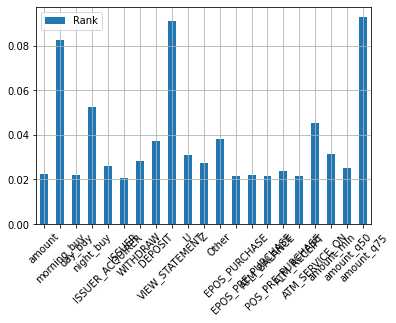

In [62]:
tree = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=150, class_weight={0:85}, min_samples_leaf=1).fit(final_df.values, response.values)
column_importances = tree.feature_importances_
import_idx = np.where(column_importances >= 0.02)[0]
column_importances = column_importances[import_idx]
columns = final_df.columns.to_numpy()[import_idx]
importance_info = np.array(list(zip(column_importances, columns)))
pd.DataFrame(column_importances, index=columns, columns=['Rank']).plot(kind='bar');
plt.grid();
plt.xticks(rotation=45);
plt.show()

In [63]:
tree_unimport_cols = []
for i in range(final_df.shape[1]):
    if i not in import_idx:
        tree_unimport_cols.append(final_df.columns[i])
print(tree_unimport_cols)

['ATMAPI', 'MOBILEAPI', 'WEBAPI', 'atm_mcc', 'evening_buy', 'PAYMENT', 'CLIENT_DEFINED', 'CARD_PIN_CHANGE', 'UPDATE_USER', 'R', 'C', 'F', 'POS_PURCHASE', 'ATM_P2P_DEBIT', 'ATM_WITHDRAW', 'ATM_CASH', 'ATM_CASH_CHECK', 'GEN_TPIN', 'ATM_P2P_CREDIT', 'ATM_PAYMENT', 'TOKENIZATION_REQUEST', 'EPOS_RETURN', 'ATM_PIN', 'ATM_ST', 'POS_BALANCE', 'POS_RETURN', 'POS_CARDLESS', 'SERVICE_INQ', 'ATM_MINI_ST', 'ATM_P2P_CHECK', 'ATM_EDITAUTOPAYMENT', 'ATM_PHONE', 'amount_max', 'amount_mean', 'amount_std', 'amount_q25']


In [64]:
final_df.columns[unimportant_columns]

Index(['GEN_TPIN', 'POS_BALANCE', 'POS_RETURN'], dtype='object')

In [65]:
print(unimportant_pca_columns)

['ATMAPI', 'amount', 'morning_buy', 'day_buy', 'evening_buy', 'night_buy', 'ISSUER_ACQUIRER', 'ISSUER', 'PAYMENT', 'WITHDRAW', 'DEPOSIT', 'VIEW_STATEMENT', 'CARD_PIN_CHANGE', 'UPDATE_USER', 'U', 'C', 'Other', 'POS_PURCHASE', 'ATM_P2P_DEBIT', 'ATM_WITHDRAW', 'ATM_CASH', 'GEN_TPIN', 'ATM_P2P_CREDIT', 'ATM_PAYMENT', 'EPOS_PURCHASE', 'EPOS_PRE_PURCHASE', 'ATM_BALANCE', 'TOKENIZATION_REQUEST', 'POS_PRE_PURCHASE', 'ATM_RECEIPT', 'POS_BALANCE', 'POS_RETURN', 'ATM_MINI_ST', 'ATM_P2P_CHECK', 'ATM_PHONE', 'amount_max', 'amount_mean', 'amount_std', 'amount_q25', 'amount_q50', 'amount_q75']


В итоге можно сделать предположение, основываясь на ANOVA test, DecisionTree и PCA анализе, что признаки **GEN_TPIN, POS_BALANCE, POS_RETURN** не привносят эффекта в отклик, и их можно убрать.
Также можно попробовать брать случайно подмножество несущественных признаков из PCA и удалять их.

In [66]:
features_to_be_removed = unimportant_columns

### Коэффициент корреляции Пирсона
Посмотрим, какие признаки хорошо скоррелированы друг с другом. При высоком коэффициенте можно сделать вывод, что эти признаки линейно зависимы, а потому данные избыточны.

In [67]:
final_df.corr()

,ATMAPI,MOBILEAPI,WEBAPI,atm_mcc,amount,morning_buy,day_buy,evening_buy,night_buy,ISSUER_ACQUIRER,...,ATM_P2P_CHECK,ATM_EDITAUTOPAYMENT,ATM_PHONE,amount_max,amount_min,amount_mean,amount_std,amount_q25,amount_q50,amount_q75
ATMAPI,1.000000,-0.795477,-0.147152,-0.118768,-0.137438,-0.108255,-0.118398,-0.126458,-0.097807,-0.118052,...,NaN,-0.005318,0.013551,-0.067711,0.030130,-0.010458,-0.030541,0.000918,0.003529,0.002010
MOBILEAPI,-0.795477,1.000000,-0.482332,0.115071,0.118963,0.105012,0.113686,0.124299,0.095922,0.113907,...,NaN,-0.017431,-0.008775,0.065937,-0.039872,-0.010834,0.026196,-0.037729,-0.041757,-0.021576
WEBAPI,-0.147152,-0.482332,1.000000,-0.016137,0.004499,-0.014916,-0.014412,-0.020083,-0.015181,-0.015272,...,NaN,0.036140,-0.005266,-0.009745,0.021526,0.032802,0.001391,0.060257,0.063057,0.032312
atm_mcc,-0.118768,0.115071,-0.016137,1.000000,0.785193,0.980125,0.996603,0.968988,0.684264,0.998453,...,NaN,-0.002713,-0.005690,0.147858,-0.028675,-0.075267,-0.045183,-0.013057,-0.047563,-0.081384
amount,-0.137438,0.118963,0.004499,0.785193,1.000000,0.729019,0.774054,0.803235,0.714178,0.776297,...,NaN,-0.004517,-0.008241,0.532335,-0.021254,0.290698,0.332676,0.150683,0.198007,0.236293
morning_buy,-0.108255,0.105012,-0.014916,0.980125,0.729019,1.000000,0.979244,0.903985,0.574694,0.982923,...,NaN,-0.002356,-0.005473,0.120713,-0.026958,-0.072763,-0.051483,-0.013273,-0.044367,-0.074404
day_buy,-0.118398,0.113686,-0.014412,0.996603,0.774054,0.979244,1.000000,0.959936,0.640604,0.997169,...,NaN,-0.002874,-0.005328,0.141062,-0.027953,-0.074031,-0.046586,-0.011175,-0.045632,-0.079630
evening_buy,-0.126458,0.124299,-0.020083,0.968988,0.803235,0.903985,0.959936,1.000000,0.766465,0.962352,...,NaN,-0.002409,-0.005805,0.166243,-0.028789,-0.076494,-0.037725,-0.015474,-0.052173,-0.086476
night_buy,-0.097807,0.095922,-0.015181,0.684264,0.714178,0.574694,0.640604,0.766465,1.000000,0.663736,...,NaN,-0.003135,-0.006550,0.239580,-0.033544,-0.047206,0.018196,-0.018331,-0.046044,-0.073272
ISSUER_ACQUIRER,-0.118052,0.113907,-0.015272,0.998453,0.776297,0.982923,0.997169,0.962352,0.663736,1.000000,...,NaN,-0.002745,-0.005428,0.138094,-0.027527,-0.074180,-0.048848,-0.012170,-0.045836,-0.078889


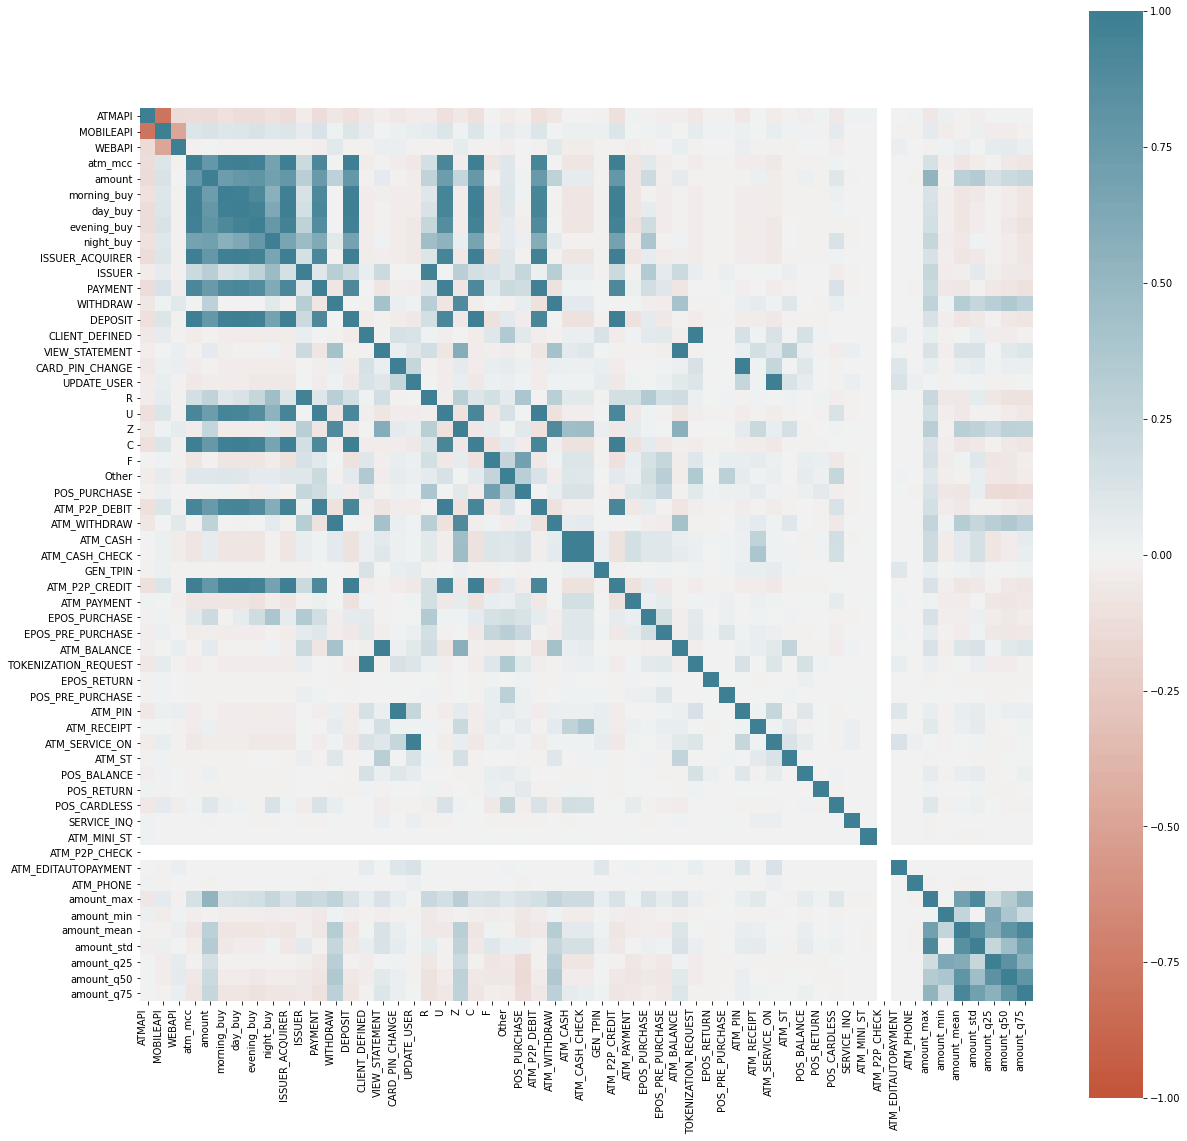

In [68]:
corr = final_df.corr()
fig, ax = plt.subplots(figsize=(20,20))  
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [70]:
def features_high_corr(gamma: float):
    high_corr_dict = {}
    corr_df = final_df.corr()
    for r in range(corr_df.shape[0]):
        feauture_corr_tmp = corr_df.iloc[r]
        feature_name = feauture_corr_tmp.name
        for f in range(feauture_corr_tmp.shape[0]):
            if f >= r:
                continue
            if np.abs(feauture_corr_tmp.iloc[f]) > gamma:
                print(f"{feature_name} <---> {feauture_corr_tmp.index[f]}: {feauture_corr_tmp.iloc[f]}")
                if feature_name not in high_corr_dict:
                    high_corr_dict[feature_name] = []
                high_corr_dict[feature_name].append(feauture_corr_tmp.index[f])
    low_importance_features = []
    for key, val in high_corr_dict.items():
        for sub_val in val:
            if sub_val not in low_importance_features:
                low_importance_features.append(sub_val)
    return high_corr_dict, low_importance_features

In [71]:
features_high_corr(0.99)

day_buy <---> atm_mcc: 0.9966029160219149
ISSUER_ACQUIRER <---> atm_mcc: 0.9984531237815952
ISSUER_ACQUIRER <---> day_buy: 0.9971694262702004
DEPOSIT <---> atm_mcc: 0.9987859369330773
DEPOSIT <---> day_buy: 0.9950216189899952
DEPOSIT <---> ISSUER_ACQUIRER: 0.9967910868772119
C <---> atm_mcc: 0.9979507635974347
C <---> day_buy: 0.9956770634472548
C <---> ISSUER_ACQUIRER: 0.9985301911017136
C <---> DEPOSIT: 0.9986141445717418
ATM_P2P_DEBIT <---> U: 0.9964228678002606
ATM_WITHDRAW <---> WITHDRAW: 0.9957688245632685
ATM_P2P_CREDIT <---> atm_mcc: 0.9986478434509239
ATM_P2P_CREDIT <---> day_buy: 0.9948988085242821
ATM_P2P_CREDIT <---> ISSUER_ACQUIRER: 0.9966658478407736
ATM_P2P_CREDIT <---> DEPOSIT: 0.9999679984699678
ATM_P2P_CREDIT <---> C: 0.9986514769373825
ATM_BALANCE <---> VIEW_STATEMENT: 0.9914097553648467
TOKENIZATION_REQUEST <---> CLIENT_DEFINED: 0.9931100279406138
ATM_PIN <---> CARD_PIN_CHANGE: 1.0
ATM_SERVICE_ON <---> UPDATE_USER: 1.0


({'day_buy': ['atm_mcc'],
  'ISSUER_ACQUIRER': ['atm_mcc', 'day_buy'],
  'DEPOSIT': ['atm_mcc', 'day_buy', 'ISSUER_ACQUIRER'],
  'C': ['atm_mcc', 'day_buy', 'ISSUER_ACQUIRER', 'DEPOSIT'],
  'ATM_P2P_DEBIT': ['U'],
  'ATM_WITHDRAW': ['WITHDRAW'],
  'ATM_P2P_CREDIT': ['atm_mcc', 'day_buy', 'ISSUER_ACQUIRER', 'DEPOSIT', 'C'],
  'ATM_BALANCE': ['VIEW_STATEMENT'],
  'TOKENIZATION_REQUEST': ['CLIENT_DEFINED'],
  'ATM_PIN': ['CARD_PIN_CHANGE'],
  'ATM_SERVICE_ON': ['UPDATE_USER']},
 ['atm_mcc',
  'day_buy',
  'ISSUER_ACQUIRER',
  'DEPOSIT',
  'U',
  'WITHDRAW',
  'C',
  'VIEW_STATEMENT',
  'CLIENT_DEFINED',
  'CARD_PIN_CHANGE',
  'UPDATE_USER'])

Признаки в последнем списке являются избыточными, так как почти однозначно линейно связаны с другими признаками. Эти признаки можно удалить, так как они зашумляют данные и могут ухудшить будущую модель.

# Разбиение выборки на отдельные части
Ниже будут рассмотрены два подхода к разбиению выборки:
1. Обычное разбиение на 3 части: тренировочная, валидационная, тестовая. В данном случае последняя выборка должна быть крайне мала и использоваться только в самом конце на лучшей модели, чтобы провести финальное измерение метрики на данных, которые модель никогда не видела
2. Стратифицированная выборка (покажет себя лучше). В данной задаче есть существенный дисбаланс классов, поэтому необходимо с большой аккуратностью выбирать данные и обучать алгоритмы. Даже при хороших значениях метрики алгоритм может ошибаться в большой количестве случаев на редком классе, так как почти всегда предсказывает самый частый класс.

In [72]:
from sklearn.model_selection import StratifiedShuffleSplit

In [73]:
# аналог train_test_split из sklearn, но может выдавать 3 набора данных
def split_dataset(X_data, Y_data, val_size=0.25, test_size=0.1, shuffle=True, random_seed=None):
    assert X_data.shape[0] == Y_data.shape[0]
    observation_num = X_data.shape[0]
    if isinstance(X_data, pd.DataFrame):
        X_data = X_data.values
    if isinstance(Y_data, pd.Series):
        Y_data = Y_data.values
    idx_order = np.arange(observation_num)
    if shuffle:
        rng = np.random.default_rng(seed=random_seed)
        idx_order = rng.permutation(idx_order)
    X_data = X_data[idx_order]
    Y_data = Y_data[idx_order]
    train_idx = int(observation_num*(1-test_size-val_size))
    if test_size > 0:
        val_idx = train_idx + int(observation_num*val_size)
        test_idx = val_idx + 1
    else:
        val_idx = train_idx + 1
    
    if test_size > 0:
        X_train, y_train = X_data[:train_idx], Y_data[:train_idx]
        X_val, y_val = X_data[train_idx:val_idx], Y_data[train_idx:val_idx]
        X_test, y_test = X_data[val_idx:], Y_data[val_idx:]
    else:
        X_train, y_train = X_data[:train_idx], Y_data[:train_idx]
        X_val, y_val = X_data[train_idx:], Y_data[train_idx:]
    
    if test_size > 0:
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_val, np.array([]), y_train, y_val, np.array([])

In [74]:
response.value_counts()

0    8516
1      66
Name: resolution, dtype: int64

In [75]:
8516/66

129.03030303030303

Выберем тестовую выборку, которая не будет участвовать ни в тренировке, ни в оценке медели. Своего рода A/B тестирование.

Возьмем по 5 наблюдений из каждого класса.

In [76]:
fraud_idx = np.where(response == 1)[0]
genuine_idx = np.where(response == 0)[0]
rng_tmp = np.random.default_rng()
fraud_idx_5 = rng_tmp.permutation(fraud_idx)[:5]
genuine_idx_5 = rng_tmp.permutation(genuine_idx)[:5]
test_idx_rand = rng_tmp.permutation(np.concatenate([fraud_idx_5, genuine_idx_5]))
X_test = final_df.loc[test_idx_rand]
y_test = response.loc[test_idx_rand]
final_df.drop(test_idx_rand, axis=0, inplace=True)
response.drop(test_idx_rand, axis=0, inplace=True)

In [77]:
X_train, X_val, _, y_train, y_val, _ = split_dataset(final_df, response, val_size=0.2, test_size=0.0)
print(X_train.shape)
print(X_val.shape)

(6857, 57)
(1715, 57)


# Построение модели

За основную модель возьмем Random Forest. У такой модели есть свои преимущества:
1. Хорошо работает на данных не с нормальным распределением
2. Работает с пропусками (мы их убрали)
3. Можно понять, какие признаки важны
4. Множество тонко настраевымых гиперпараметров

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
forest_clf = RandomForestClassifier().fit(X_train, y_train)

За отправную точку метрикм возьмем accuracy: 0.3, recall: 0.1 для положительного класса.

*Recall* - та метрика, которую надо максимально увеличить.

Напишем функцию, которая вычисляет все метрики разом

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, confusion_matrix, classification_report

In [81]:
def estimate_score(y_true, y_pred):
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall:    {recall_score(y_true, y_pred)}")
    print(f"F1 Score:  {f1_score(y_true, y_pred)}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true=y_true, y_pred=y_pred))

In [82]:
pred_val = forest_clf.predict(X_val)
estimate_score(y_val, pred_val)

Precision: 1.0
Recall:    0.42857142857142855
F1 Score:  0.6
Confusion Matrix:
[[1701    0]
 [   8    6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1701
           1       1.00      0.43      0.60        14

    accuracy                           1.00      1715
   macro avg       1.00      0.71      0.80      1715
weighted avg       1.00      1.00      0.99      1715



Результат уже неплохой, но есть вероятность, что модель переобучилась. Попробуем убрать некоторые признаки и проверить еще раз результат.

In [83]:
X_train, X_val, _, y_train, y_val, _ = split_dataset(final_df.drop(final_df.columns[features_to_be_removed], axis=1), response, val_size=0.2, test_size=0.0)
forest_only_import_f = RandomForestClassifier().fit(X_train, y_train)
estimate_score(y_val, forest_only_import_f.predict(X_val))

Precision: 1.0
Recall:    0.4444444444444444
F1 Score:  0.6153846153846153
Confusion Matrix:
[[1706    0]
 [   5    4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1706
           1       1.00      0.44      0.62         9

    accuracy                           1.00      1715
   macro avg       1.00      0.72      0.81      1715
weighted avg       1.00      1.00      1.00      1715



Такой подход только практические не изменил предыдущий результат. Поэтому стоит воспользоваться методом стратифицированной выборки (чтобы обучаться на данных, в которых присутствуют одинаковые пропорции классов) и смотреть на метрику f1-score, так как она являются средним геометрическим от *precision* и *recall*.

### Стратифицированная выборка

In [84]:
from sklearn.model_selection import StratifiedShuffleSplit

In [85]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)
forest_clf = RandomForestClassifier(warm_start=True, n_jobs=-1)
scores = []
for train_index, test_index in sss.split(final_df.values, response.values):
    forest_clf.fit(final_df.values[train_index], response.values[train_index])
    scores.append(recall_score(response.values[test_index], forest_clf.predict(final_df.values[test_index])))
    forest_clf.n_estimators += 50
print('Mean Recall: ', np.mean(scores))

Mean Recall:  0.7083333333333334


Довольно неплохой результат.

## Поиск наилучших гиперпараметров

In [103]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [113]:
X_train, X_val, _, y_train, y_val, _ = split_dataset(final_df, response, val_size=0.2, test_size=0.0)

Построим модель по следующиму принципу: будем искать рандомизированно лучшие параметры, используя стратифицированные выборки, оптимизируя метрику f1. После 10 проходов смотрим лучшие параметры моделей, выбираем минимум и максимум, обновляем сетку поиска и запускаем поиск еще раз. Таким образом за 10 раз автоматизированно можно приблизиться к наилучшим параметрам.

In [ ]:
def update_serach_grid(score_tmp, score_curr):
    

In [114]:
forest_grid = {
    'n_estimators': stats.randint(37, 329),
    'max_depth': stats.randint(3, 5),
    'min_samples_split': stats.randint(2, 5),
    'ccp_alpha': stats.uniform(loc=0, scale=0.9)
}
for j in tqdm(range(20)):
    scores = list()
    for i in range(20):
        forest = RandomForestClassifier(criterion='entropy', oob_score=True, class_weight='balanced')
        rand_search = RandomizedSearchCV(forest, param_distributions=forest_grid, cv=5, n_jobs=8, scoring='f1', n_iter=20)
        rand_search.fit(final_df.values, response.values)
        scores.append(rand_search.best_params_)
        score_tmp = {'ccp_alpha': [1e8, 0],
                      'max_depth': [1e8, 0],
                      'min_samples_split': [1e8, 0],
                      'n_estimators': [1e8, 0]}
        for score in scores:
            if score['max_depth'] < score_tmp['max_depth'][0]:
                score_tmp['max_depth'][0] = score['max_depth']
            if score['max_depth'] > score_tmp['max_depth'][1]:
                score_tmp['max_depth'][1] = score['max_depth']
                
            if score['min_samples_split'] < score_tmp['min_samples_split'][0]:
                score_tmp['min_samples_split'][0] = score['min_samples_split']
            if score['min_samples_split'] > score_tmp['min_samples_split'][1]:
                score_tmp['min_samples_split'][1] = score['min_samples_split']
                
            if score['n_estimators'] < score_tmp['n_estimators'][0]:
                score_tmp['n_estimators'][0] = score['n_estimators']
            if score['n_estimators'] > score_tmp['n_estimators'][1]:
                score_tmp['n_estimators'][1] = score['n_estimators']
            
            if score['ccp_alpha'] < score_tmp['ccp_alpha'][0]:
                score_tmp['ccp_alpha'][0] = score['ccp_alpha']
            if score['ccp_alpha'] > score_tmp['ccp_alpha'][1]:
                score_tmp['ccp_alpha'][1] = score['ccp_alpha']
                
        forest_grid = {
            'n_estimators': stats.randint(score_tmp['n_estimators'][0], score_tmp['n_estimators'][1]+1),
            'max_depth': stats.randint(score_tmp['max_depth'][0], score_tmp['max_depth'][1]+1),
            'min_samples_split': stats.randint(score_tmp['min_samples_split'][0], score_tmp['min_samples_split'][1]+1),
            'ccp_alpha': stats.uniform(loc=score_tmp['ccp_alpha'][0], scale=score_tmp['ccp_alpha'][1]+1)
        }

 10%|█         | 2/20 [12:10<1:49:31, 365.11s/it]


KeyboardInterrupt: 

In [107]:
rand_search.best_params_

{'class_weight': {0: 1, 1: 8},
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 299}

In [108]:
rand_search.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 8}, max_depth=3,
                       min_samples_split=3, n_estimators=299)

In [110]:
forest_clf = RandomForestClassifier(class_weight='balanced', max_depth=3, min_samples_split=3, n_estimators=299)
forest_clf.fit(X_train, y_train)
estimate_score(y_val, forest_clf.predict(X_val))

Precision: 0.057971014492753624
Recall:    0.4444444444444444
F1 Score:  0.10256410256410256
Confusion Matrix:
[[1641   65]
 [   5    4]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1706
           1       0.06      0.44      0.10         9

    accuracy                           0.96      1715
   macro avg       0.53      0.70      0.54      1715
weighted avg       0.99      0.96      0.97      1715



In [112]:
X_train

array([[0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 2.43425e+02,
        5.86780e+02, 9.50745e+02],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 5.29500e+02,
        1.69715e+03, 6.18750e+03],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.09000e+02,
        4.32475e+02, 3.12500e+03],
       ...,
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 2.80000e+01,
        4.50000e+01, 8.75000e+01],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        4.84890e+02, 2.85000e+04],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 1.58600e+02,
        5.00000e+02, 1.50000e+04]])

In [111]:
estimate_score(y_test, forest_clf.predict(X_test))

ValueError: X has 57 features, but DecisionTreeClassifier is expecting 54 features as input.

In [92]:
estimate_score(response, forest_clf.predict(final_df))

ValueError: X has 57 features, but DecisionTreeClassifier is expecting 54 features as input.

Это наилучший результат.

In [ ]:
forest_clf.get_params()

### Попытка написать класс для случайного леса, внутри которого используется стратифицированная выборка